## install and import neccessary libraries ##

In [1118]:
# ! pip install pandas numpy scikit-learn requests

In [1119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
import os
import requests

## prepare data to analysis and prediction ##
source: "https://dane.gov.pl/pl"

In [1120]:
def download_file(url, destination):

    try:
        response = requests.get(url)

        if response.status_code == 200:
            with open(destination, "wb") as f:
                f.write(response.content)
            print(f"File downloaded successfully: {destination}")
        else:
            print(f"Failed to download the file from {url}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error downloading file from {url}: {e}")

csv_urls = [
    "https://api.dane.gov.pl/media/resources/20240126/7_-_Wykaz_imion_%C5%BCe%C5%84skich_wg_pola_imi%C4%99_pierwsze_wyst%C4%99puj%C4%85cych_w_rejestrze_PESEL_z_uwzgl%C4%99dnieniem_imion_os%C3%B3b_zmar%C5%82ych_EpBAXbE.csv", 
    "https://api.dane.gov.pl/media/resources/20240126/7_-_Wykaz_imion_m%C4%99skich_wg_pola_imi%C4%99_pierwsze_wyst%C4%99puj%C4%85cych_w_rejestrze_PESEL_z_uwzgl%C4%99dnieniem_imion_os%C3%B3b_zmar%C5%82ych.csv"
]

output_dir = "data"

os.makedirs(output_dir, exist_ok=True)

In [1121]:
for i, url in enumerate(csv_urls):
    file_name = f"data_{i+1}.csv"
    file_path = os.path.join(output_dir, file_name)
    
    if os.path.exists(file_path):
        print(f"File already exists: {file_path}")
    else:
        download_file(url, file_path)

File already exists: data\data_1.csv
File already exists: data\data_2.csv


concatenate both source .csv files in one pandas dataframe

In [1122]:
df = pd.concat(
    map(pd.read_csv, [r"data\data_1.csv", r"data\data_2.csv"]), ignore_index=True
    )

df.sample(5)

,IMIĘ_PIERWSZE,PŁEĆ,LICZBA_WYSTĄPIEŃ
45706,NITHEESH,MĘŻCZYZNA,4
20052,EVLALIYA,KOBIETA,2
9298,HYOJIN,KOBIETA,6
10533,ILLINA,KOBIETA,5
26688,OLGIERD,MĘŻCZYZNA,4551


In [1123]:
df = df.rename(columns={
    "IMIĘ_PIERWSZE": "name", 
    "PŁEĆ": "sex", 
    "LICZBA_WYSTĄPIEŃ": "occurencies"
})

df['sex'] = df['sex'].map(lambda x: "man" if x=='MĘŻCZYZNA' else "woman")

data overwiev

In [1124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65789 entries, 0 to 65788
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         65788 non-null  object
 1   sex          65789 non-null  object
 2   occurencies  65789 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [1125]:
df_null_values = df[df.isnull().any(axis=1)]
df_null_values

,name,sex,occurencies
2773,NaN,woman,35


In [1126]:
duplicates = df[df.duplicated(keep=False)]
len(duplicates)

0

df.info() gives us information about null values, such quantity has no significance for the analyzed set and  can be ignored/ deleted

In [1127]:
df = df.dropna(axis=0)
df.groupby(by='sex')['name'].count()

sex
man      39360
woman    26428
Name: name, dtype: int64

we create the first feature to make our first prediction. <br>
To predict any value, we need to establish at least 2 values,<br>
one that will be predicted <br>
and the other that will be our base for analysis by the model and creation of the prediction.<br>
The data for analysis must be in 2-dimensional form, e.g. a matrix, the prediction data in 1-dimensional form, e.g. a list

In [1128]:
df['nameLenght'] = df['name'].map(lambda x: len(x))
df = df[df['nameLenght'] >= 3]
df.sort_values(by='nameLenght', ascending=True).head()

,name,sex,occurencies,nameLenght
44128,TÀI,man,4,3
16767,DEE,woman,3,3
16810,NEO,woman,3,3
16822,MEE,woman,3,3
16848,NGO,woman,3,3


In [1129]:
feat = ['nameLenght']

df['target_value'] = df['sex'].map(lambda x: int(x=='man'))

In [1130]:
model1 = LogisticRegression()

X = df[feat]
y = df['target_value']


In [1131]:
X.shape, y.shape

((65623, 1), (65623,))

to prevent overfitting we split whole dataset to train and test data 80/20%

In [1132]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [1133]:
def train_and_predict(X_train, X_test, y_train, y_test, model, success_metric=accuracy_score):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_score = success_metric(y_test, y_pred)
    print(f"accuracy score for {model} is: {round(accuracy_score, 2)*100}%")
    return y_pred

In [1134]:
firstPrediction =train_and_predict(X_train, X_test, y_train, y_test, model1)


accuracy score for LogisticRegression() is: 60.0%


In [1135]:
model2 = LogisticRegression(solver="lbfgs", verbose=1, max_iter=100, n_jobs=5)

In [1136]:
secondPrediction = train_and_predict(X_train, X_test, y_train, y_test, model2)

accuracy score for LogisticRegression(n_jobs=5, verbose=1) is: 60.0%


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [1137]:
vowels = "aeiouyAEIOUY"

df['lastIsVowel'] = df['name'].map(lambda x: int(x[-1] in vowels))
df['firstIsVowel'] = df['name'].map(lambda x: int(x[0] in vowels))

df.head()

,name,sex,occurencies,nameLenght,target_value,lastIsVowel,firstIsVowel
0,ANNA,woman,1365614,4,0,1,1
1,MARIA,woman,1013781,5,0,1,0
2,ZOFIA,woman,722555,5,0,1,0
3,KATARZYNA,woman,681719,9,0,1,0
4,MAŁGORZATA,woman,626147,10,0,1,0


In [1138]:
features = ['nameLenght', 'lastIsVowel', 'firstIsVowel']
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

thirdPrediction = train_and_predict(X_train, X_test, y_train, y_test, model1)

accuracy score for LogisticRegression() is: 72.0%


In [1139]:
fourthPrediction = train_and_predict(X_train, X_test, y_train, y_test, model2)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


accuracy score for LogisticRegression(n_jobs=5, verbose=1) is: 72.0%


In [1140]:
model5 = DecisionTreeClassifier()

fifthPrediction = train_and_predict(X_train, X_test, y_train, y_test, model5)   

accuracy score for DecisionTreeClassifier() is: 72.0%


In [1141]:
model6 = XGBClassifier()

sixthPrediction = train_and_predict(X_train, X_test, y_train, y_test, model6)

accuracy score for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) is: 72.0%


In [1142]:
df = df.drop(columns=['occurencies'])
df = df.drop_duplicates(subset=['name'], keep="first")
df.head()

,name,sex,nameLenght,target_value,lastIsVowel,firstIsVowel
0,ANNA,woman,4,0,1,1
1,MARIA,woman,5,0,1,0
2,ZOFIA,woman,5,0,1,0
3,KATARZYNA,woman,9,0,1,0
4,MAŁGORZATA,woman,10,0,1,0


In [1143]:
df.groupby('sex')['name'].count()

sex
man      36333
woman    26362
Name: name, dtype: int64

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor

In [1144]:
model7 = RandomForestClassifier()
model8 = GradientBoostingClassifier()
# model9 = RandomForestRegressor()

seventhPrediction = train_and_predict(X_train, X_test, y_train, y_test, model7) 
eighthPrediction = train_and_predict(X_train, X_test, y_train, y_test, model8)  
# ninthPrediction = train_and_predict(X_train, X_test, y_train, y_test, model9)


accuracy score for RandomForestClassifier() is: 72.0%
accuracy score for GradientBoostingClassifier() is: 72.0%


In [1145]:
# import necessary modules from scikit-learn
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from matplotlib import pyplot as plt

# define the functon with some parameters like:
# model - used ML model
# title - specifies title of the plot
# X - input data
# y - target variable
# ylim - sets the border limit for the y-axis of the plot
# cd - param of cross-validation strategy used to evaluate the performance of a model by splitting the data into multiple subsets
# n_jobs - the number of parallel jobs to run during cross-validation. If set to '-1' all available processors wil lbe used, if '1' no parallel computing code will be used
# train_sizes - param that determines the sizes of the training set used to generate the learning curve. By default it generates 5 evenly spaced values between 10-100% of the tr.data
def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
# sets up the plot with, define its size, title and y-axis limit if does not set
    plt.figure(figsize=(10,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
# generates learning_curve function from scikit-learn. It computes test ant train scores for different trainind set sizes
    train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
# calculates mean and std dev. of train and test scores across different trainig set sizes
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
# fills the area around the mean train and sets scores  to represent     
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
# plots the mean train and test scores against training set sizes and adds a legend
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

# returns the plot object
    return plt

c:\Users\marcint\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marcint\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marcint\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\marcin

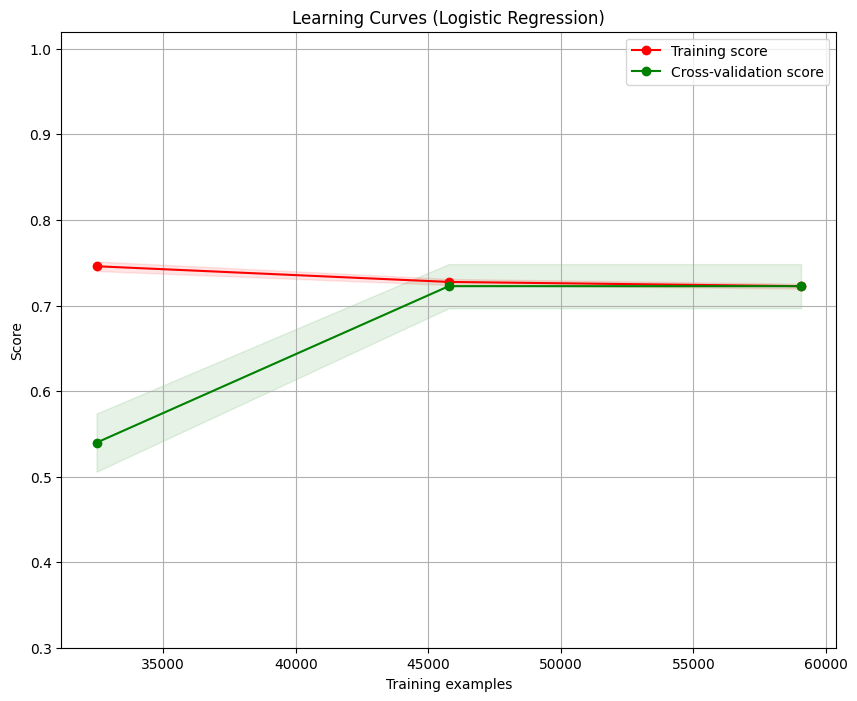

In [1146]:
plt = plot_learning_curve(model1, 
                          "Learning Curves (Logistic Regression)", 
                          X, y, ylim=(0.3, 1.02), cv=10, n_jobs=5)
plt.show()

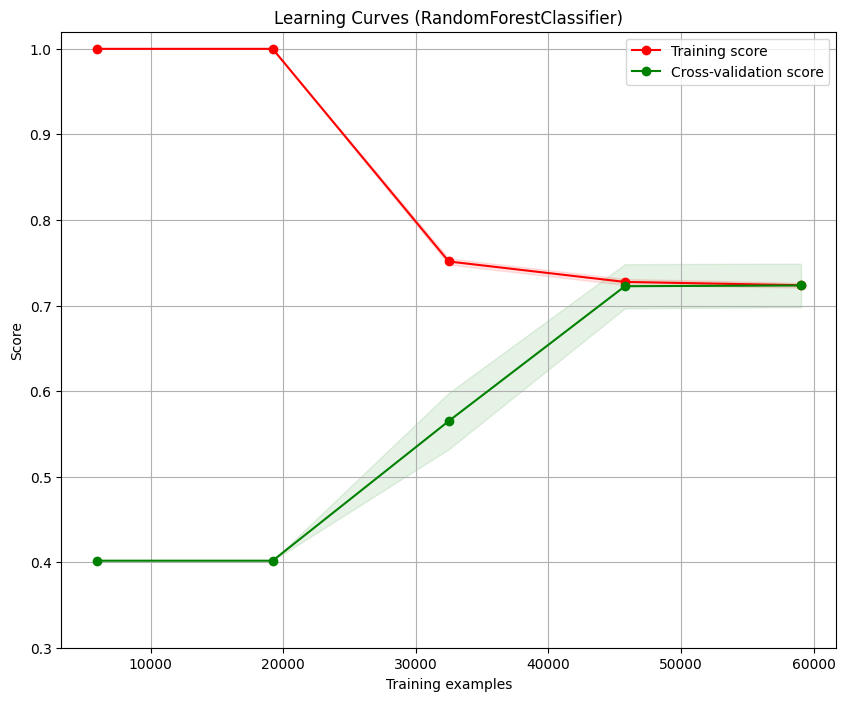

In [1147]:
plt = plot_learning_curve(model7, 
                          "Learning Curves (RandomForestClassifier)", 
                          X, y, ylim=(0.3, 1.02), cv=10, n_jobs=5)
plt.show()

In [1148]:
def draw_feature_importances(model, features):
    # Calculate feature importances using the provided model
    importances = model.feature_importances_
    
    # Sort the indices of feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Now 'indices' contains the indices of features sorted by their importance
    # For example, if the first element of 'indices' is 2, then the third feature 
    # has the highest importance according to the model
    
    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

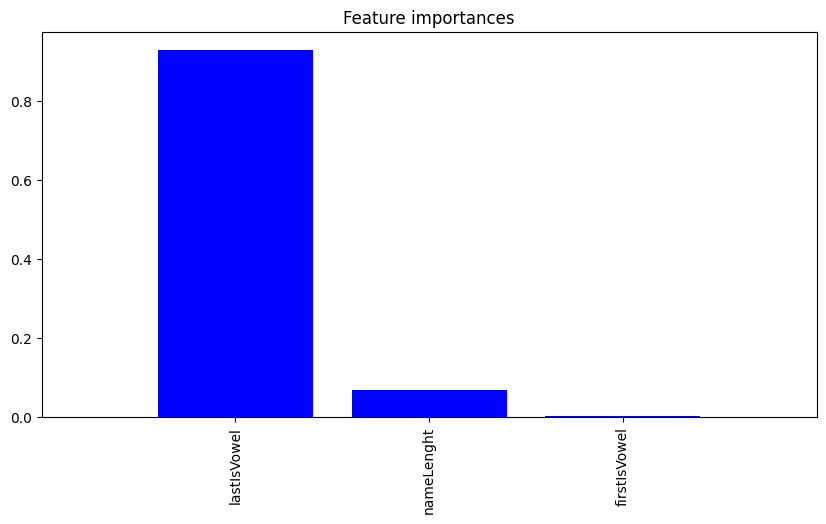

In [1149]:
draw_feature_importances(model7, features)